### Prototype hirarchical clustering
Put it in a clean Python file later

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
%matplotlib inline

In [2]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

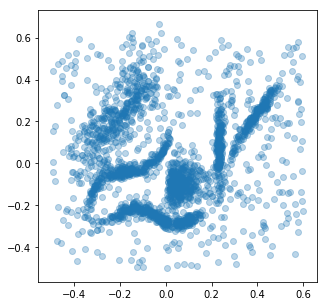

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [4]:
fuzzy

array([[-0.12153499, -0.22876337],
       [-0.22093687, -0.25251088],
       [ 0.1259037 , -0.27314321],
       ..., 
       [ 0.50243143, -0.3002958 ],
       [ 0.53822256,  0.19412199],
       [-0.08688887, -0.2092721 ]])

In [5]:
fuzzy_copy = deepcopy(fuzzy)
np.random.shuffle(fuzzy)

In [6]:
def merge_sets(X, i, j):
    X[i] = X[i].union(X[j])
    del X[j]

In [7]:
def square_to_condensed(i, j, n):
    assert i != j, "no diagonal elements in condensed matrix"
    if i < j:
        i, j = j, i
    return int(n*j - j*(j+1)/2 + i - 1 - j)

def calc_row_ind(k, n):
    return int(np.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_ind(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_ind(k, n)
    j = calc_col_ind(k, i, n)
    return i, j

In [8]:
def fit_slow(data, k, link='average', metric='euclidian'):
    
    # TODO: Optimize if-statements (e.g. choose appropriate function in beginning, s.t. they are
    #not done every time)

    # Safety checks
    assert any((link=='average', link=='complete', link=='single')), "unknown link type"
    
    # Init
    cur_num_clusters = n
    clusters = [set([i]) for i in range(n)]
    cluster_dists = distance.pdist(data, metric)
    #print(cluster_dists)
    delete_inds = np.array(range(n))
    dist_func = 0
    
    # Specify cluster distance function
    if link == 'average':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: (ilen * llen * cluster_dists[li] + jlen * llen * cluster_dists[lj]) / ((ilen + jlen) * llen)
    elif link == 'single':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: min(cluster_dists[li], cluster_dists[lj])
    elif link == 'complete':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: max(cluster_dists[li], cluster_dists[lj])

    while cur_num_clusters > k:

        # Find two clusters to merge, according to crit
        i_min, j_min = condensed_to_square(cluster_dists.argmin(), cur_num_clusters) # are ordered     
        ilen = len(clusters[i_min])
        jlen = len(clusters[j_min])

        # Update cluster distances
        for l in range(cur_num_clusters):
            if any((l == i_min, l == j_min)):
                continue
            llen = len(clusters[l])
            li = square_to_condensed(l, i_min, cur_num_clusters)
            lj = square_to_condensed(l, j_min, cur_num_clusters)
            cluster_dists[li] = dist_func(cluster_dists, li, lj, ilen, jlen)

        # Delete all j_min-Distances
        delete_inds = [square_to_condensed(l, j_min, cur_num_clusters) for l in 
                       range(cur_num_clusters) if l != j_min]
        cluster_dists = np.delete(cluster_dists, delete_inds)

        # Merge the two clusters, nearest according to crit
        merge_sets(clusters, i_min, j_min)
        cur_num_clusters -= 1

    # Assign data points to clusters
    labels = np.ones(n).astype(int)
    for i, cluster in enumerate(clusters):
        for elt in cluster:
            labels[elt] = i
    return labels

In [9]:
def fit(data, link='average', num_stop_crit=1, metric='euclidian', verbose=True, **kwargs):

    # Safety checks
    assert any((link=='average', link=='complete', link=='single')), "unknown link type"
    
    # Get keyword arguments
    k = kwargs.get('k')
    stop_dist = kwargs.get('stop_dist')
    
    #print(k)
    #print(stop_dist)
    
    # Init
    cur_num_clusters = n
    clusters = [set([i]) for i in range(n)]
    #cluster_dists_condensed = distance.pdist(data, metric)
    #cluster_dists = distance.squareform(cluster_dists_condensed)
    cluster_dists = distance.squareform(distance.pdist(data, metric))
    cluster_sizes = np.ones(n)
    #print(cluster_dists)
    delete_inds = np.array(range(n))
    #dist_func = 0
    cur_stop_crit = 0
    if verbose:
        start_time = timer()
    k_reached = False
    stop_dist_reached = False
    
    # Specify cluster distance function
    if link == 'average':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: (ilen * cluster_dists[li] + jlen * cluster_dists[lj]) / (ilen + jlen)
    elif link == 'single':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: min(cluster_dists[li], cluster_dists[lj])
    elif link == 'complete':
        dist_func = lambda cluster_dists, li, lj, ilen, jlen: max(cluster_dists[li], cluster_dists[lj])

    while cur_stop_crit < num_stop_crit:

        # Find two clusters to merge, according to crit
        #i_min, j_min = condensed_to_square(cluster_dists_condensed.argmin(), cur_num_clusters) # are ordered
        np.fill_diagonal(cluster_dists, cluster_dists.max())
        #i_min = np.argmin(cluster_dists, axis=0)
        #j_min = np.argmin(cluster_dists, axis=1)
        #min_ind = cluster_dists.flatten().argmin()
        i_min, j_min = np.unravel_index(cluster_dists.argmin(), (cur_num_clusters, cur_num_clusters))
        #i_min = min_ind // cur_num_clusters
        #j_min = min_ind % cur_num_clusters
        ilen = cluster_sizes[i_min]
        jlen = cluster_sizes[j_min]

        # Update cluster distances
        # CAN I DO THAT DIRECTLY WITH MATRIX?? Without any for-loop?
        
        # ich muss in in die i-te reihe...
        if link == 'average':
            cluster_dists[i_min, :] = (ilen * cluster_dists[i_min, :] 
                                       + jlen * cluster_dists[j_min, :]) / (ilen + jlen)
        if link == 'single':
            cluster_dists[i_min, :] = np.minimum(cluster_dists[i_min, :], cluster_dists[j_min, :])
        if link == 'complete':
            cluster_dists[i_min, :] = np.maximum(cluster_dists[i_min, :], cluster_dists[j_min, :])
        cluster_dists[:, i_min] = cluster_dists[i_min, :]
            
        # AAH dist_func wird gar nicht mehr benutzt!
        
        #cluster_dists[i_min, i_min] = 0
        #for l in range(cur_num_clusters):
        #    if any((l == i_min, l == j_min)):
        #        continue
        #    #llen = len(clusters[l])
        #    li = square_to_condensed(l, i_min, cur_num_clusters)
        #    lj = square_to_condensed(l, j_min, cur_num_clusters)
        #    cluster_dists_condensed[li] = dist_func(cluster_dists_condensed, li, lj, ilen, ilen)

        # Delete all j_min-Distances
        # NOT CONDENSED, BUT SQUARE!
        #delete_inds = [square_to_condensed(l, j_min, cur_num_clusters) for l in 
        #               range(cur_num_clusters) if l != j_min]
        #cluster_dists_condensed = np.delete(cluster_dists_condensed, delete_inds)
        #cluster_dists_condensed = distance.squareform(cluster_dists, checks=False)
        #cluster_dists_condensed = distance.squareform(cluster_dists, checks=False)
        #...
        #cluster_dists = np.delete(cluster_dists, j_min, axis=0)
        #cluster_dists = np.delete(cluster_dists, j_min, axis=1)
        cluster_dists[j_min, :] = # hm nee auf maximum setzen funktioniert glaube ich nicht, weil
        # dieses maximum ja irgendwann wieder das minimum werden könnte...
        # vielleicht einfach die beiden Spalten & Zeilen gleich setzen?
        # ...aber das funktioniert auch nicht. Dann müsste ich ja ganz viele Spalten und Zeilen
        # neu setzen...
        ##################
        ##################
        ### CHECKPOINT ###
        ##################
        ##################
        # also wenn ich davon ausgehe, dass ich nichts löschen will in *der* matrix, dann muss ich alles updaten denke ich...
        cluster_dists = np.delete(cluster_dists, j_min, axis=1)

        # Merge the two nearest clusters, adjust sizes
        merge_sets(clusters, i_min, j_min)
        cluster_sizes[i_min] += cluster_sizes[j_min]
        cluster_sizes = np.delete(cluster_sizes, j_min)
        cur_num_clusters -= 1
        
        # Count fulfilled stopping criteria
        if all((k is not None, cur_num_clusters <= k)):
            k_reached = True
        if all((stop_dist is not None, cluster_dists.min() > stop_dist)):
            stop_dist_reached = True
        cur_stop_crit = sum([k_reached, stop_dist_reached])
        
    # Algorithm verbosity
    if verbose:
        print("Hierarchical clustering terminated.")
        elapsed_time = timer() - start_time
        elapsed_time = timedelta(seconds=elapsed_time)
        print("Finished after " + str(elapsed_time))
        if (k_reached):
            print("Stopping cluster number was reached.")
        print("Current number of clusters: {0}".format(cur_num_clusters))
        if (stop_dist_reached):
            print("Stopping distance was reached.")
        print("Current minimum cluster distance: {:.2}".format(cluster_dists.min()))

    # Assign data points to clusters
    labels = np.zeros(n).astype(int)
    for i, cluster in enumerate(clusters):
        for elt in cluster:
            labels[elt] = i
    return labels

770
Hierarchical clustering terminated.
Finished after 0:00:02.128220
Stopping cluster number was reached.
Current number of clusters: 10
Stopping distance was reached.
Current minimum cluster distance: 0.31


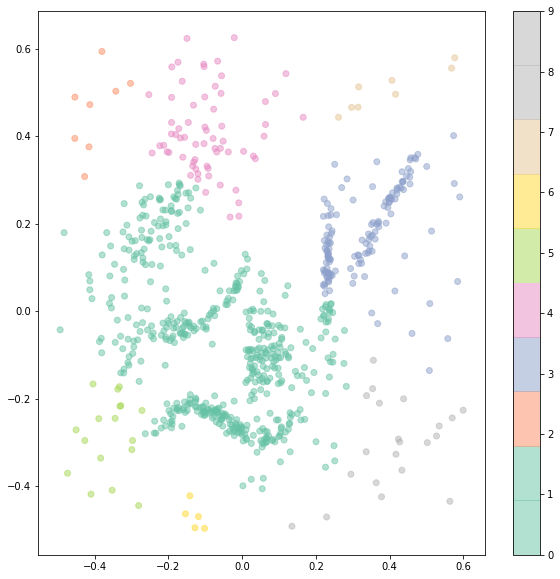

In [11]:
#%%time
k = 10 # number of clusters to go down to
stop_dist = 0.3
num_stop_crit = 1
stride = 3
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

#labels = fit_slow(data=data, num_clusters=k, link=link, metric=metric)
labels = fit(data, link=link, num_stop_crit=num_stop_crit, metric=metric, k=k, stop_dist=stop_dist)
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
#plt.scatter(x[::stride,0], x[::stride,1], c=labels, alpha=.4)
plt.colorbar()

In [46]:
test1 = False
test = 1 if test1 else 2
test

2

In [27]:
a=1
b=2
print("a is {0}, b is {1}".format(a, b))

a is 1, b is 2


In [11]:
test = np.array(range(4)).reshape((2,2))
test.max()

3

1155
Wall time: 7.08 s


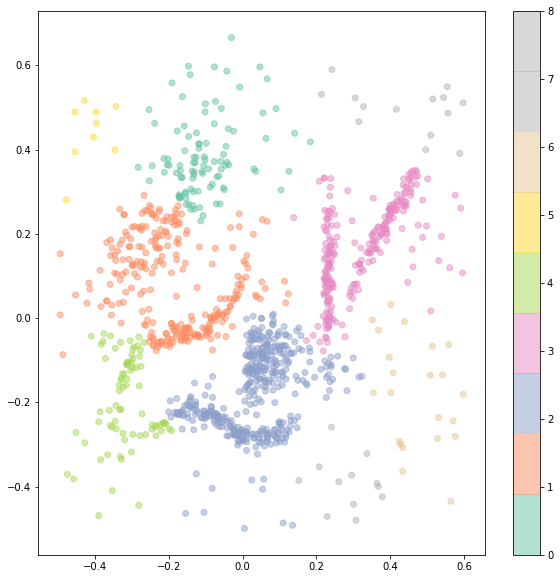

In [67]:
%%time
k = 9 # number of clusters to go down to
stride = 2
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

#labels = fit_slow(data=data, num_clusters=k, link=link, metric=metric)
labels = fit(data=data, num_clusters=k, link=link, metric=metric)
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
#plt.scatter(x[::stride,0], x[::stride,1], c=labels, alpha=.4)
plt.colorbar()

In [60]:
test1 = np.array([1, 2, 5, 3])
test2 = np.array([2, 1, 6, 2])
np.minimum(test1, test2)

array([1, 1, 5, 2])

In [40]:
test = np.arange(16).reshape((4, 4))
np.fill_diagonal(test, test.max())
test[2, 3] = -1
print(test)
print(test.flatten())
min_ind = test.flatten().argmin()
print(min_ind)
print(min_ind // 4)
print(min_ind % 4)

#print(np.argmin(test, axis=0))
#print(test[:, np.argmin(test, axis=0)])
#print((np.argmin(test[:, np.argmin(test, axis=0)], axis=1)))

[[15  1  2  3]
 [ 4 15  6  7]
 [ 8  9 15 -1]
 [12 13 14 15]]
[15  1  2  3  4 15  6  7  8  9 15 -1 12 13 14 15]
11
2
3


In [18]:
test = np.arange(16).reshape((4, 4))
print(np.fill_diagonal(test, 5))
print(test)

None
[[ 5  1  2  3]
 [ 4  5  6  7]
 [ 8  9  5 11]
 [12 13 14  5]]


In [45]:
test = np.arange(16).reshape((4, 4))
np.delete(test, 1, axis=1)

array([[ 0,  2,  3],
       [ 4,  6,  7],
       [ 8, 10, 11],
       [12, 14, 15]])

In [22]:
test1 = test2 = np.array([2, 3])
test1*test2

array([4, 9])

462


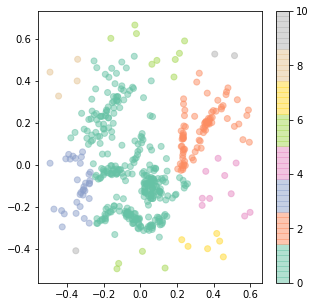

In [337]:
k = 11 # number of clusters to go down to
stride = 5
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

labels = fit(data=data, num_clusters=k, link=link, metric=metric)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', num_clusters), alpha=.5)
#plt.scatter(x[::stride,0], x[::stride,1], c=labels, alpha=.4)
plt.colorbar()

0
2
[{0, 1, 2, 4}, {3}, {5}]
[[ 0.          0.48804432  0.42579643]
 [ 0.48804432  0.          0.54451141]
 [ 0.42579643  0.54451141  0.        ]]
4
1
1
[[ 0.          0.49933774  0.42579643]
 [ 0.49933774  0.          0.54451141]
 [ 0.42579643  0.54451141  0.        ]]
[[ 0.          0.49933774]
 [ 0.49933774  0.        ]]


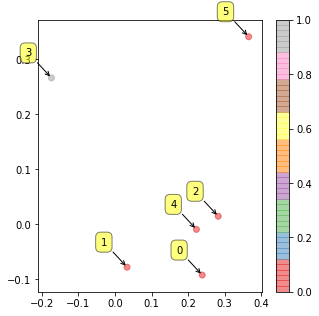

In [318]:
k = 2 # number of clusters to go down to
stride = 401
data = fuzzy[::stride]
n = len(data) # number of data points
#print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

labels = fit(data=data, num_clusters=k, link=link, metric=metric)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set1', num_clusters), alpha=.5)
#plt.scatter(x[::stride,0], x[::stride,1], c=labels, alpha=.4)
plt.colorbar()
for i, x, y in zip(range(n), data[:, 0], data[:, 1]):
    plt.annotate(
        i,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

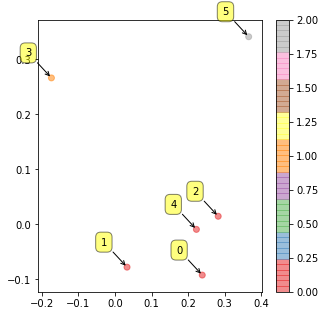

In [319]:
k = 3 # number of clusters to go down to
stride = 401
data = fuzzy[::stride]
n = len(data) # number of data points
#print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

labels = fit(data=data, num_clusters=k, link=link, metric=metric)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set1', num_clusters), alpha=.5)
#plt.scatter(x[::stride,0], x[::stride,1], c=labels, alpha=.4)
plt.colorbar()
for i, x, y in zip(range(n), data[:, 0], data[:, 1]):
    plt.annotate(
        i,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [233]:
x

0.096136651561816111

Set parameters and fit

In [321]:
print(labels[labels==1])
print(np.unique(labels))
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 1 2 3 4 5 6 7]
[0 0 1 0 2 0 0 0 2 1 1 0 2 0 2 2 3 0 1 0 2 0 1 1 1 0 1 0 2 0 1 0 0 1 0 1 0
 0 0 0 0 2 0 1 1 1 2 0 2 1 0 0 0 0 0 1 0 3 3 0 0 0 0 0 1 0 0 0 0 0 4 0 0 0
 0 0 0 0 0 1 1 0 0 1 4 2 0 0 1 2 2 0 1 3 1 2 1 3 5 0 0 0 1 2 2 5 0 5 3 2 0
 1 0 0 2 0 3 0 1 3 0 3 4 0 0 2 0 1 3 0 1 0 0 5 2 0 0 1 0 2 0 4 0 3 2 3 2 1
 0 0 1 6 0 4 0 2 2 0 0 4 0 1 0 0 1 0 0 1 0 2 3 0 0 1 4 1 6 2 0 0 2 0 0 3 0
 4 2 0 0 0 3 0 0 2 0 2 0 0 0 1 5 1 0 0 0 2 2 1 1 2 0 0 5 0 3 0 0 3 0 6 1 2
 0 0 0 3 0 2 0 0 0 0 0 2 2 5 1 2 0 0 0 1 2 1 0 4 3 0 2 2 0 0 0 2 0 2 2 7 0
 2 0 0 1 2 1 1 1 6 2 1 2 0 0 2 4 0 3 1 0 0 0 0 1 3 2 0 0 3 0 0 0 1 1 3 0 0
 0 0 1 0 0 0 1 1 3 2 2 3 1 0 2 0 2 0 3 0 2 0 4 2 2 2 0 0 0 3 0 2 3 0 0 2 0
 0 0 0 2 4 4 0 7 3 0 0 5 2 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 2 0 0 2 0 1 0 4
 2 0 0 1 0 1 0 0 0 0 1 1 0 1 0 2 3 2 3 0 0 0 2 0 0 0 4 0 0 2 1 2 2 2

EXTREM LANGSAM :/ UND ER ASSIGNED VIEL ZU WENIGE GLEICHE LABELS. CHECKE DAS NOCH MAL

In [118]:
delete_inds = range(5)
j_min = 2
np.delete(delete_inds, j_min)
delete_inds = [square_to_condensed(delete_inds[:], j_min, 5)]
delete_inds

TypeError: unorderable types: range() < int()

TESTE MIT BILDERN indem ich in einer for-Schleife immer nur bis ein Cluster weniger gehe und ein Bild plotte (nimm dafür nur wenige Datenpunkte, vielleicht 50)

Test condensed index stuff

In [11]:
test = distance.pdist(list(zip(range(5), np.zeros(5))))
distance.squareform(test)

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  0.,  1.,  2.,  3.],
       [ 2.,  1.,  0.,  1.,  2.],
       [ 3.,  2.,  1.,  0.,  1.],
       [ 4.,  3.,  2.,  1.,  0.]])

In [12]:
test

array([ 1.,  2.,  3.,  4.,  1.,  2.,  3.,  1.,  2.,  1.])

SETZE DOCH MAL JMIN UND TESTE DAS LÖSCHEN!

In [21]:
j_min = 2
num_clusters = 5
delete_inds = [square_to_condensed(l, j_min, num_clusters) for l in range(num_clusters) if l != j_min]
print(delete_inds)
print(test)
test2 = np.delete(test, delete_inds)
print(test2)
#print(test)

[1, 4, 7, 8]
[ 1.  2.  3.  4.  1.  2.  3.  1.  2.  1.]
[ 1.  3.  4.  2.  3.  1.]


In [22]:
distance.squareform(test2)

array([[ 0.,  1.,  3.,  4.],
       [ 1.,  0.,  2.,  3.],
       [ 3.,  2.,  0.,  1.],
       [ 4.,  3.,  1.,  0.]])

In [84]:
test[square_to_condensed(1, 2, 5)]

1.0

In [87]:
min_ind = test.argmin()
min_ind

0

In [94]:
condensed_to_square(min_ind+7, 5)

(2, 3)

In [68]:
(test[test > 0].argmin(axis=0))

0

In [67]:
test[test > 0]

array([ 1.,  2.,  3.,  4.,  1.,  1.,  2.,  3.,  2.,  1.,  1.,  2.,  3.,
        2.,  1.,  1.,  4.,  3.,  2.,  1.])

Test set merge stuff

In [99]:
test = [set([i]) for i in range(5)]

In [100]:
test

[{0}, {1}, {2}, {3}, {4}]

In [102]:
merge_sets(test, 1, 3)

In [103]:
test

[{0}, {1, 3}, {2}, {4}]

In [104]:
merge_sets(test, 1, 3)

In [105]:
test

[{0}, {1, 3, 4}, {2}]

In [106]:
test[1]

{1, 3, 4}

In [108]:
for pt in test[1]:
    print(pt)

1
3
4
